### Load libraries

In [2]:
import pathlib
import sys

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision.datasets
from tqdm.auto import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)

sys.path.append(str(GIT_ROOT))

from src.pretrain import linear_probe

### Load data

In [4]:
# Load mnist data
root = "/var/tmp/scratch"
mnist_train = torchvision.datasets.MNIST(root, train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root, train=False, download=True)

XS_TRAIN, YS_TRAIN = mnist_train.data.numpy(), mnist_train.targets.numpy()
XS_TEST, YS_TEST = mnist_test.data.numpy(), mnist_test.targets.numpy()

XS_TRAIN = XS_TRAIN.reshape(-1, 28 * 28)
XS_TEST = XS_TEST.reshape(-1, 28 * 28)
print(XS_TRAIN.shape, YS_TRAIN.shape, XS_TEST.shape)

DS = linear_probe.Dataset(XS_TRAIN, YS_TRAIN, XS_TEST, YS_TEST)

(60000, 784) (60000,) (10000, 784)


### Collect scaling data

In [5]:
DATA = []

In [6]:
for n_train in tqdm(list(range(1, 16)) + [32, 64, 100, 500, 1000]):
    for C in [0.01, 1, 100]:
        for seed in range(10):
            for n_classes in [2, 5, 10]:
                DATA.append(
                    linear_probe.run_experiment(
                        ds=DS,
                        n_train=n_train,
                        n_classes=n_classes,
                        C=C,
                        max_iter=10000,
                        seed=seed,
                    )
                )

  0%|          | 0/20 [00:00<?, ?it/s]

/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: div

In [7]:
for n_train in tqdm([5000, 10000, 60000]):
    for C in [0.01]:
        for seed in range(3):
            for n_classes in [2, 5, 10]:
                DATA.append(
                    linear_probe.run_experiment(
                        ds=DS,
                        n_train=n_train,
                        n_classes=n_classes,
                        C=C,
                        max_iter=10000,
                        seed=seed,
                    )
                )

  0%|          | 0/3 [00:00<?, ?it/s]

/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.log(aprobs[np.arange(len(aprobs)), labs_test]).mean()
/home/gridsan/twang/code/scaling/src/pretrain/linear_probe.py:34: RuntimeWarning: div

# Analyze data

In [8]:
df = pd.DataFrame(DATA)
# df = pd.read_csv("mnist-scaling.csv")
df["err"] = 1 - df.acc
df

,n_classes,C,max_iter,seed,n_train,acc,xent,err
0,2,0.01,10000,0,1,0.536643,inf,0.463357
1,5,0.01,10000,0,1,0.200817,inf,0.799183
2,10,0.01,10000,0,1,0.102800,inf,0.897200
3,2,0.01,10000,1,1,0.463357,inf,0.536643
4,5,0.01,10000,1,1,0.196536,inf,0.803464
...,...,...,...,...,...,...,...,...
1822,5,0.01,10000,1,30596,0.958552,0.307220,0.041448
1823,10,0.01,10000,1,60000,0.920900,0.344799,0.079100
1824,2,0.01,10000,2,12665,0.999527,0.046747,0.000473
1825,5,0.01,10000,2,30596,0.958552,0.307818,0.041448


In [9]:
# df.to_csv("mnist-scaling.csv", index=False)

### MNIST scaling

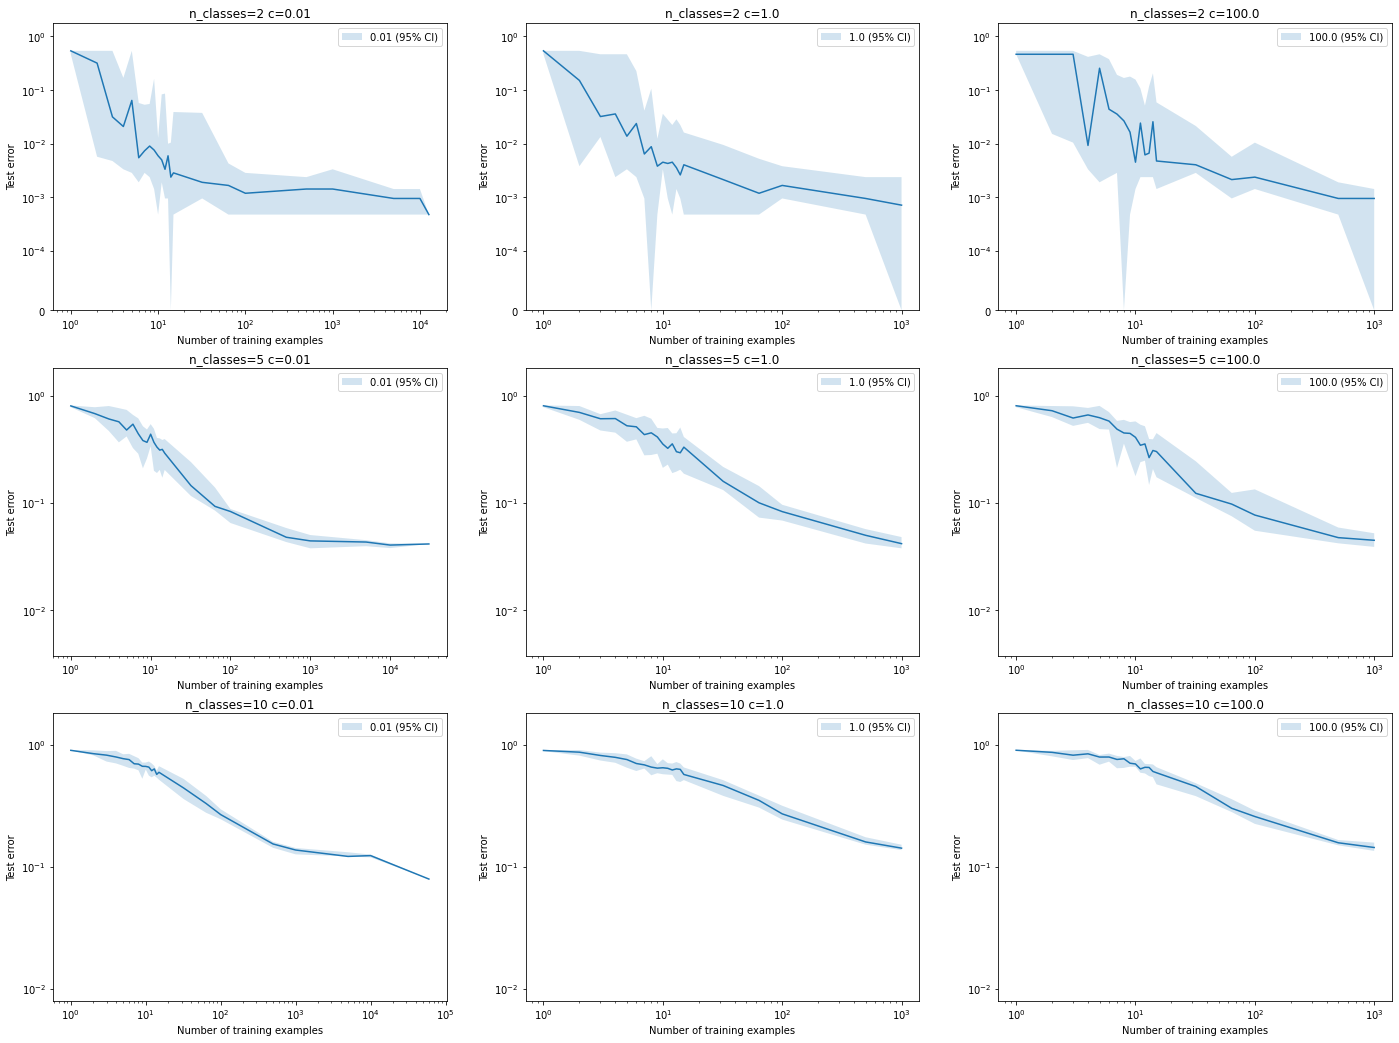

In [10]:
plt.figure(figsize=(24, 18))

plot_idx = 0
for i, n_classes in enumerate(df.n_classes.unique()):
    for c in sorted(df.C.unique()):
        plot_idx += 1
        plt.subplot(df.n_classes.nunique(), df.C.nunique(), plot_idx)

        gb = df.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).err
        lo = gb.min()
        mid = gb.median()
        hi = gb.max()

        plt.plot(mid.index, mid)
        plt.fill_between(
            mid.index, lo, hi, alpha=0.2, label=f"{c} (95% CI)"
        )

        plt.ylim(0.1 * df.query(f"n_classes == {n_classes}").err.min(), 2 * df.err.max())

        plt.title(f"{n_classes=} {c=}")
        plt.legend()
        plt.xscale("log")
        plt.yscale("symlog", linthresh=1e-4)
        plt.xlabel("Number of training examples")
        plt.ylabel("Test error")

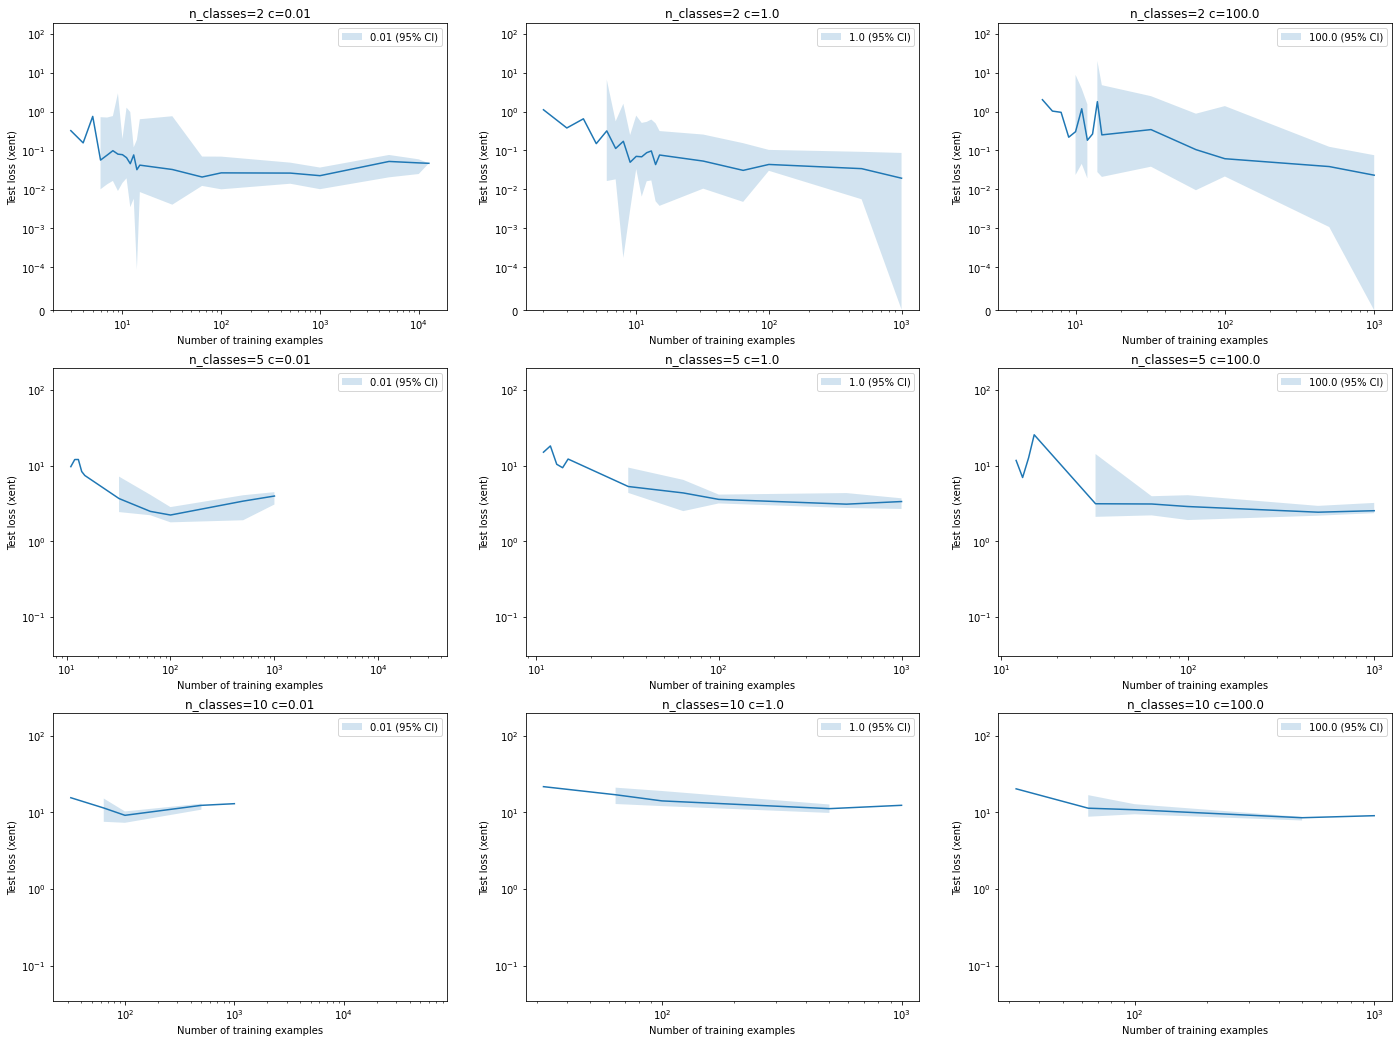

In [11]:
plt.figure(figsize=(24, 18))

plot_idx = 0
for i, n_classes in enumerate(df.n_classes.unique()):
    for c in sorted(df.C.unique()):
        plot_idx += 1
        plt.subplot(df.n_classes.nunique(), df.C.nunique(), plot_idx)

        gb = df.query(f"n_classes == {n_classes} & C == {c}").groupby(
            "n_train"
        ).xent
        lo = gb.min()
        mid = gb.median()
        hi = gb.max()

        plt.plot(mid.index, mid)
        plt.fill_between(
            mid.index, lo, hi, alpha=0.2, label=f"{c} (95% CI)"
        )

        with pd.option_context('mode.use_inf_as_na', True):
            plt.ylim(0.1 * df.query(f"n_classes == {n_classes}").xent.min(), 2 * df.dropna().xent.max())

        plt.title(f"{n_classes=} {c=}")
        plt.legend()
        plt.xscale("log")
        plt.yscale("symlog", linthresh=1e-4)
        plt.xlabel("Number of training examples")
        plt.ylabel("Test loss (xent)")